In [20]:
import torch; torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
from sklearn.manifold import TSNE
import time


# Now we begin with the variational autoencoder

To transform the autoencoder (AE) into a Variational Autoencoder (VAE), there are a few steps we need to perform:

1. The encoder should produce two vectors: one for the mean (mu) and another one for the log variance (log_var) of the latent space representation.
2. We sample from this distribution using the reparameterization trick to get the latent vector.
3. The decoder reconstructs the input from the sampled latent vector.

4. The loss function of a VAE is composed of two terms: the reconstruction loss and the KL divergence loss. The KL divergence term regularizes the latent space by making the distribution of the latent vectors close to a standard normal distribution.

In [41]:
class VAE(nn.Module):
    def __init__(self, **kwargs):
        self.input_shape = kwargs["input_shape"]
        self.latent_dims = kwargs["latent_dims"]
        self.hidden_dims = kwargs["hidden_dims"]
        self.out_features = 128
        super().__init__()


        self.encoder = nn.Sequential(
            nn.Linear(self.input_shape, self.hidden_dims),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dims, self.latent_dims),
            nn.LeakyReLU(0.2)
            )

        # adding a latent mean and variance layer
        # this means that the input to our decoder will be the distribution of our data rather than individual samples

        self.mean__layer = nn.Linear(self.latent_dims, 2)
        self.log_var__layer = nn.Linear(self.latent_dims, 2)



        self.decoder = nn.Sequential(
            nn.Linear(2, self.latent_dims),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dims, self.hidden_dims),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dims, self.input_shape),
            nn.Sigmoid()
            )

    def reparametrize(self, mean, log_var):
        var = torch.exp(0.5*log_var)
        eps = torch.randn_like(var) # normal dist of variance
        return mean + eps*var # this is the reparametrization trick

    def forward(self, features):
        x = self.encoder(features)
        mean = self.mean__layer(x)
        log_var = self.log_var__layer(x)
        z = self.reparametrize(mean, log_var)
        x = self.decoder(z)
        return x, mean, log_var




In [42]:
def loss_using_KL_divergence(sample, prediction, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(prediction, sample, reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KL_divergence


In [43]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using {} device".format(device))

Using mps device


In [44]:
model = VAE(input_shape=28*28, latent_dims=200, hidden_dims=400).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [45]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [46]:

model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean__layer): Linear(in_features=200, out_features=2, bias=True)
  (log_var__layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [69]:
torch.manual_seed(42) # the answer to life the universe and everything
patience = 10
epochs_without_improvement = 0
best_loss = float('inf')
epochs = 50
loss_history = []
val_history = []
time_start = time.time()
for epoch in range(epochs):
    overall_loss = 0
    for batch_features,_ in train_loader:
        batch_features = batch_features.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        outputs, mean, log_var = model(batch_features)
        loss = loss_using_KL_divergence(batch_features, outputs, mean, log_var)
        overall_loss += loss.item()

        loss.backward()
        optimizer.step()



    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, overall_loss))
    loss_history.append(overall_loss)

time_end = time.time()
print('Training took {} seconds'.format(time_end - time_start))
print('Finished Training')




epoch : 1/50, loss = 8062887.725586
epoch : 2/50, loss = 8050720.644531
epoch : 3/50, loss = 8056579.333008
epoch : 4/50, loss = 8049627.479492
epoch : 5/50, loss = 8066584.571289
epoch : 6/50, loss = 8053428.386719
epoch : 7/50, loss = 8053014.218750
epoch : 8/50, loss = 8049110.812500
epoch : 9/50, loss = 8057937.710938
epoch : 10/50, loss = 8049414.990234
epoch : 11/50, loss = 8046932.935547
epoch : 12/50, loss = 8040835.920898
epoch : 13/50, loss = 8056015.505859
epoch : 14/50, loss = 8049417.358398
epoch : 15/50, loss = 8042969.348633
epoch : 16/50, loss = 8037582.703125
epoch : 17/50, loss = 8038210.662109
epoch : 18/50, loss = 8044268.463867
epoch : 19/50, loss = 8044458.879883
epoch : 20/50, loss = 8035923.087891
epoch : 21/50, loss = 8031661.868164
epoch : 22/50, loss = 8038327.880859
epoch : 23/50, loss = 8033030.221680
epoch : 24/50, loss = 8034204.087891
epoch : 25/50, loss = 8040317.473633
epoch : 26/50, loss = 8036180.314453
epoch : 27/50, loss = 8028785.086914
epoch : 28

In [63]:
# save model
torch.save(model.state_dict(), 'vae_model.pth')


In [64]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean,var]], dtype=torch.float).to(device)
    model.eval()
    output = model.decoder(z_sample)
    output = output.view(-1, 28, 28).cpu()
    output = output.detach().numpy()
    plt.imshow(output[0], cmap='gray')
    plt.show()



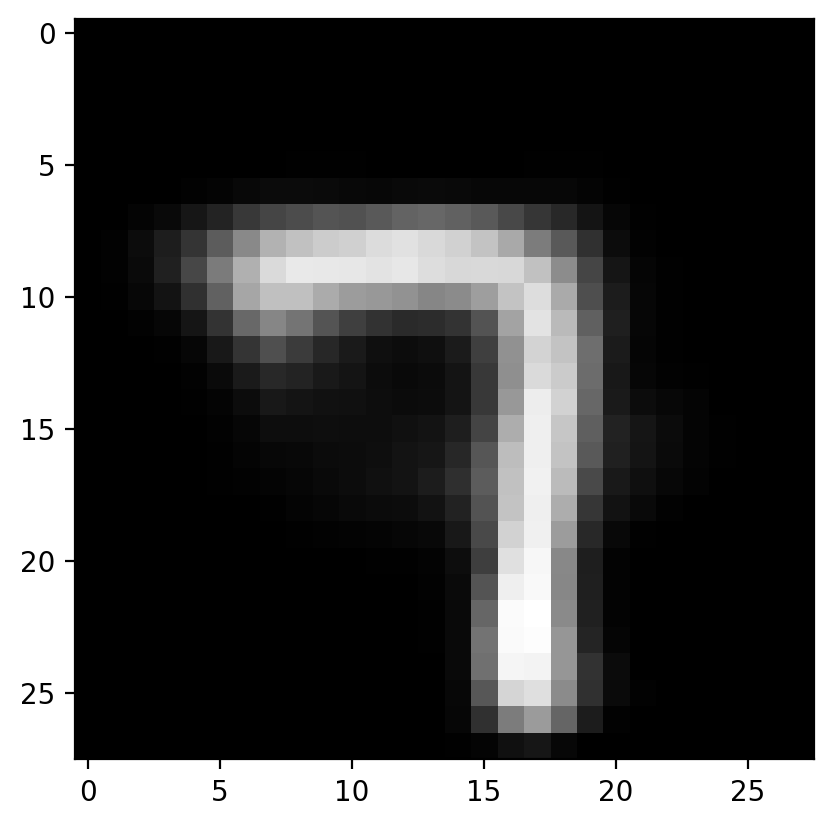

In [71]:
generate_digit(0.4, 0.4)

In [67]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

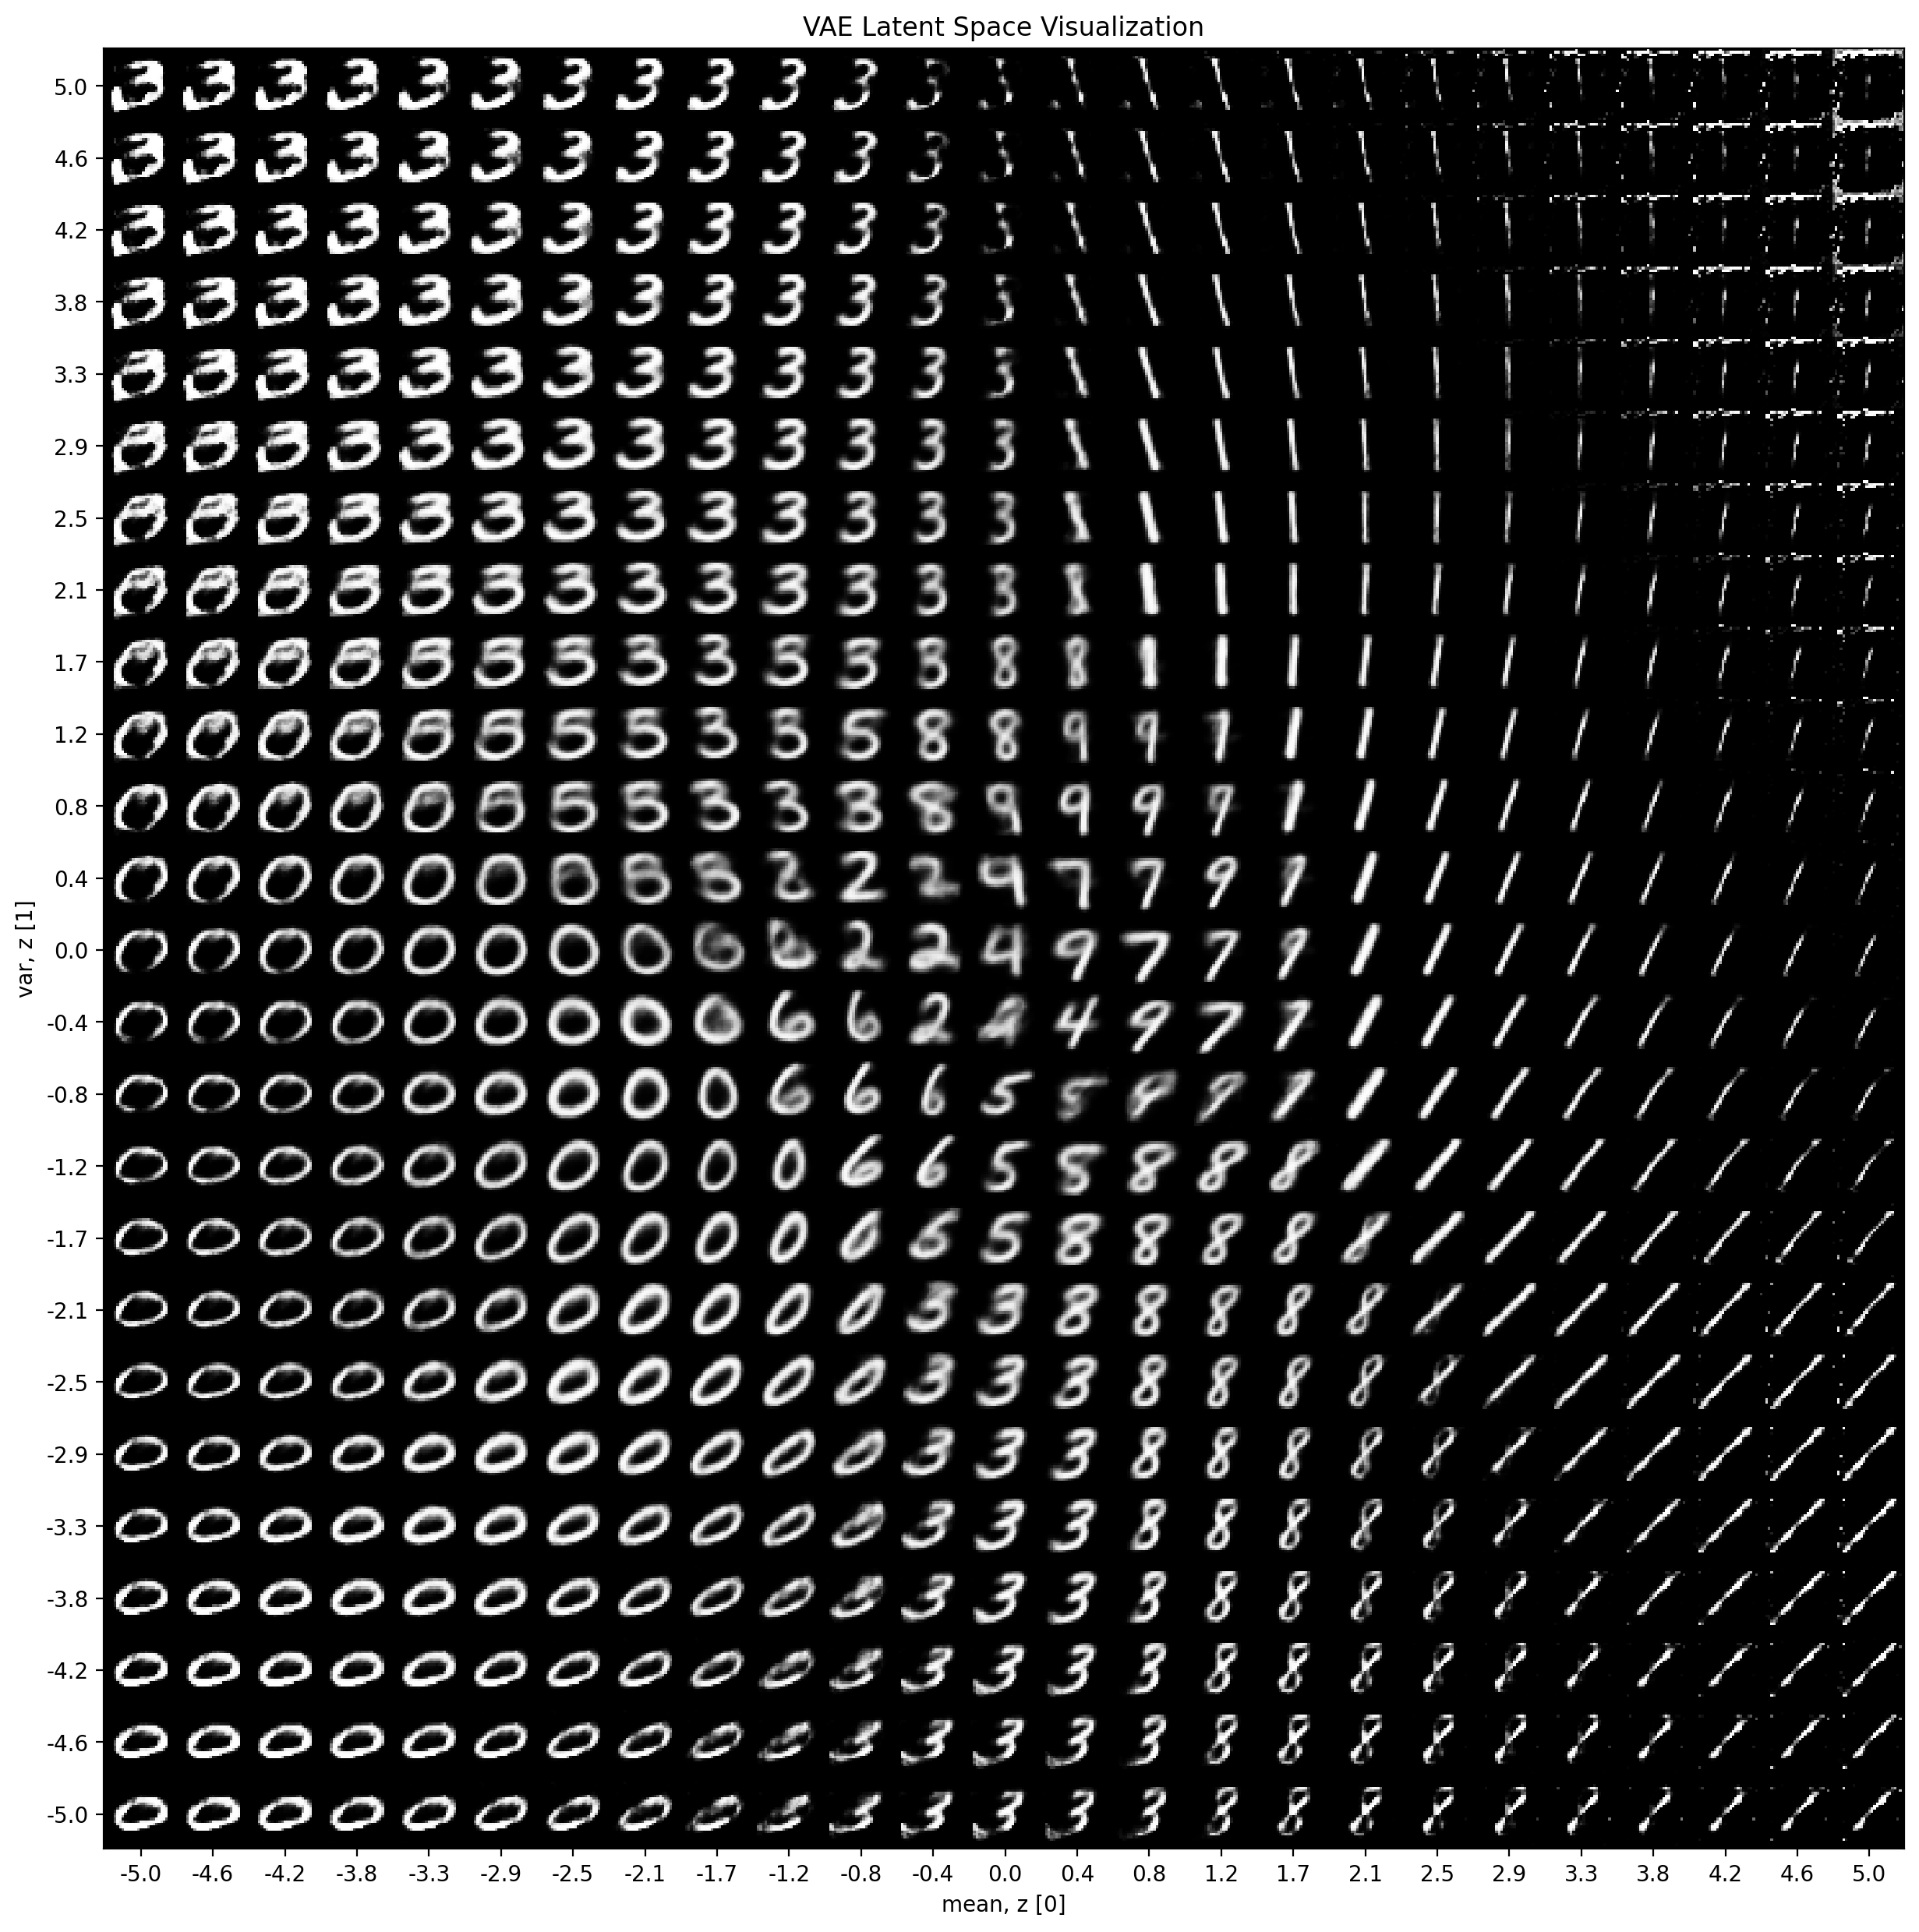

In [68]:
plot_latent_space(model)